In [20]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver # this save the chathistory in RAM

In [ ]:
from langgraph.graph.message import add_messages  # it a reducer

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]    # baseMessage mean AI human and system message inherite from base message,,    and also add message help to maintain all the message history not deleted it.

In [22]:
load_dotenv()
import os

if not os.getenv("GROQ_API_KEY"):    print("Warning: GROQ_API_KEY not set. Create a .env with GROQ_API_KEY or set the environment variable to call the API.")


model = ChatGroq(model="llama-3.1-8b-instant")

In [24]:
def chat_node(state: ChatState):
    messages= state['messages']

    responce=model.invoke(messages)

    return{'messages': [responce]}


    

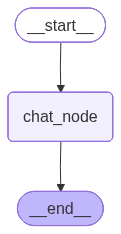

In [26]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer = checkpointer)

chatbot

In [6]:
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}

chatbot.invoke(initial_state)

{'messages': [HumanMessage(content='What is the capital of india', additional_kwargs={}, response_metadata={}, id='79ae520c-c1b3-4362-ba06-6a2979335f05'),
  AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 41, 'total_tokens': 50, 'completion_time': 0.006724701, 'completion_tokens_details': None, 'prompt_time': 0.001945914, 'prompt_tokens_details': None, 'queue_time': 0.005422025, 'total_time': 0.008670615}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b4493-7b35-72c0-912d-1ed54aecf51d-0', usage_metadata={'input_tokens': 41, 'output_tokens': 9, 'total_tokens': 50})]}

In [13]:
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}

A_message=chatbot.invoke(initial_state)
A_message['messages'][-1].content

'The capital of India is New Delhi.'

# The Below cell code cannot keep the previous chathistory, becuse we again and again invoke ans when one you invoke it by default eras or delete the history that why,

In [17]:
# Interactive chat loop WITHOUT memory
def chat():
    
    while True:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        print("human message : ",user_input)
        
        # Check if user wants to exit
        if user_input.lower() in ['exit', 'quit', 'bye', 'goodbye']:
            print("\n🤖 Chatbot: Goodbye! Have a great day!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Get chatbot response (no memory - each message is independent)
        try:
            initial_state = {'messages': [HumanMessage(content=user_input)]}
            response = chatbot.invoke(initial_state)
            bot_response = response['messages'][-1].content
            
            # Display bot response
            print(f"\n🤖 Chatbot: {bot_response}")
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Please try again.")

# Run the chat
if __name__ == "__main__":
    chat()

human message :  Hello, My name is walid khan

🤖 Chatbot: Hello Walid Khan, it's nice to meet you. Is there something I can help you with or would you like to chat?
human message :  Now Tell me what is my name?

🤖 Chatbot: I don't have any information about your name. I'm a conversational AI, and our conversation has just started. I don't retain any information about individual users, so I won't be able to recall your name if you don't tell me. Would you like to introduce yourself?
human message :  exit

🤖 Chatbot: Goodbye! Have a great day!


# 1:  python List to keep the chathistory below code:


In [18]:
# Interactive chat loop     this code will now manitain the history
def chat():
    print("🤖 Chatbot: Hello! I'm your AI assistant. Type 'exit' to end the conversation.")
    print("-" * 60)
    
    conversation_history = []
    
    while True:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        print("Human_message",user_input)
        
        # Check if user wants to exit
        if user_input.lower() in ['exit', 'quit', 'bye', 'goodbye']:
            print("\n🤖 Chatbot: Goodbye! Have a great day!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Get chatbot response with full conversation history
        try:
            # Pass all previous messages plus the new user input
            current_state = {'messages': conversation_history + [HumanMessage(content=user_input)]}
            response = chatbot.invoke(current_state)
            
            # Update conversation history with all messages from response
            conversation_history = response['messages']
            bot_response = conversation_history[-1].content
            
            # Display bot response
            print(f"\n🤖 Chatbot: {bot_response}")
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Please try again.")

# Run the chat
if __name__ == "__main__":
    chat()

🤖 Chatbot: Hello! I'm your AI assistant. Type 'exit' to end the conversation.
------------------------------------------------------------
Human_message Heloo my name is walid khan

🤖 Chatbot: Hello Walid Khan, nice to meet you. Is there something I can help you with or would you like to chat?
Human_message what is my name

🤖 Chatbot: Your name is Walid Khan.
Human_message exit

🤖 Chatbot: Goodbye! Have a great day!


# 2: To keep chathistory in RAM temporary Below code :
## but this when we restart the program  and again run so it will also forgot becuse tempory in Ram

In [27]:
# Interactive chat loop WITHOUT memory
def chat():
    thread_id = '1'
    
    while True:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        print("human message : ",user_input)
        
        # Check if user wants to exit
        if user_input.lower() in ['exit', 'quit', 'bye', 'goodbye']:
            print("\n🤖 Chatbot: Goodbye! Have a great day!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Get chatbot response (no memory - each message is independent)
        try:
            initial_state = {'messages': [HumanMessage(content=user_input)]}
            config = {'configurable':{'thread_id': thread_id}}
            response = chatbot.invoke(initial_state,config=config)
            bot_response = response['messages'][-1].content
            
            # Display bot response
            print(f"\n🤖 Chatbot: {bot_response}")
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Please try again.")

# Run the chat
if __name__ == "__main__":
    chat()# To keep chathistory in RAM temporary 

human message :  Hello, My name is walid khan

🤖 Chatbot: Hello Walid Khan, it's nice to meet you. Is there something I can help you with or would you like to chat?
human message :  can you tell me my name?

🤖 Chatbot: Your name is Walid Khan.
human message :  exit

🤖 Chatbot: Goodbye! Have a great day!
